In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format = "-", start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)
  
  
def trend(time, slope = 0):
  return slope * time

In [3]:
def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change it if you wish"""
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude = 1, phase = 0):
  """Repeats the same pattern at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [4]:
time = np.arange(4 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [5]:
## Create the series
series = baseline + trend(time, slope) + \
         seasonality(time, period = 365, amplitude = amplitude)

## Update with noise
series += noise(time, noise_level, seed = 42)

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, 
                 drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1,
                 drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30

train_set = windowed_dataset(x_train, window_size, batch_size = 128,
                             shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                           strides = 1, padding = "causal",
                           activation = "relu",
                           input_shape = [None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

In [10]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(train_set, epochs = 100,
                    callbacks = [lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 [==============================] - 8s 92ms/step - loss: 73.6163 - mae: 74.1154
Epoch 2/100
8/8 [==============================] - 1s 88ms/step - loss: 72.8992 - mae: 73.3982
Epoch 3/100
8/8 [==============================] - 1s 84ms/step - loss: 71.7509 - mae: 72.2500
Epoch 4/100
8/8 [==============================] - 1s 81ms/step - loss: 70.3121 - mae: 70.8111
Epoch 5/100
8/8 [==============================] - 1s 87ms/step - loss: 68.6372 - mae: 69.1363
Epoch 6/100
8/8 [==============================] - 1s 82ms/step - loss: 66.6965 - mae: 67.1954
Epoch 7/100
8/8 [==============================] - 1s 80ms/step - loss: 64.5149 - mae: 65.0137
Epoch 8/100
8/8 [==============================] - 1s 86ms/step - loss: 62.0192 - mae: 62.5179
Epoch 9/100
8/8 [==============================] - 1s 81ms/step - loss: 59.1778 - mae: 59.6764
Epoch 10/100
8/8 [==============================] - 1s 84ms/step - loss: 55.8527 - mae: 56.3513
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

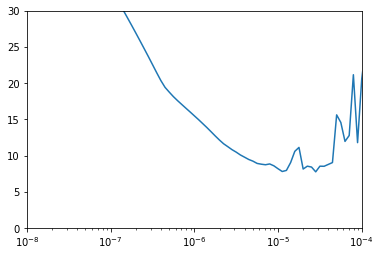

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])

plt.axis([1e-8, 1e-4, 0, 30])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

## batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size = 128,
                           shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 3,
                           strides = 1, padding = "causal",
                           activation = "relu",
                           input_shape = [None, 1]),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(dataset, epochs = 500)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
8/8 [==============================] - 4s 45ms/step - loss: 39.1145 - mae: 39.6118
Epoch 2/500
8/8 [==============================] - 0s 45ms/step - loss: 20.7392 - mae: 21.2351
Epoch 3/500
8/8 [==============================] - 1s 46ms/step - loss: 15.3516 - mae: 15.8450
Epoch 4/500
8/8 [==============================] - 0s 44ms/step - loss: 12.6203 - mae: 13.1111
Epoch 5/500
8/8 [==============================] - 1s 47ms/step - loss: 11.3789 - mae: 11.8676
Epoch 6/500
8/8 [==============================] - 0s 45ms/step - loss: 10.8404 - mae: 11.3273
Epoch 7/500
8/8 [==============================] - 1s 45ms/step - loss: 10.5180 - mae: 11.0047
Epoch 8/500
8/8 [==============================] - 0s 46ms/step - loss: 10.3072 - mae: 10.7939
Epoch 9/500
8/8 [==============================] - 1s 46ms/step - loss: 10.0939 - mae: 10.5797
Epoch 10/500
8/8 [==============================] - 0s 44ms/step - loss: 9.9279 - mae: 10.4145
Epoch 11/500
8/8 [==============================] 

In [13]:
lstm_forecast = model_forecast(model, series[..., np.newaxis],
                               window_size)

lstm_forecast = lstm_forecast[split_time - window_size:-1, -1, 0]

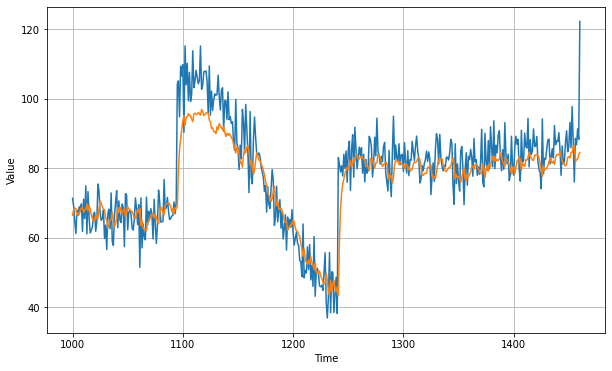

In [14]:
plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()

5.4672

<Figure size 432x288 with 0 Axes>

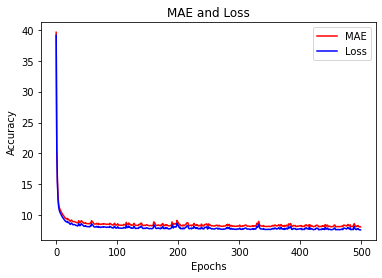

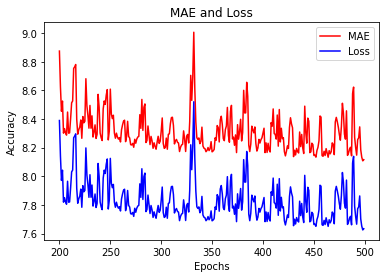

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#-------------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-------------------------------------------------------------

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))    # Get number of epochs

#-------------------------------------------------------------
# Plot MAE and Loss
#-------------------------------------------------------------

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

#-------------------------------------------------------------
# Plot Zoomed MAE and Loss
#-------------------------------------------------------------

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


dataset = windowed_dataset(x_train, window_size, batch_size = 32,
                           shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 3,
                           strides = 1, padding = "causal",
                           activation = "relu",
                           input_shape = [None, 1]),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(dataset, epochs = 500)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
31/31 [==============================] - 5s 31ms/step - loss: 21.9671 - mae: 22.4622
Epoch 2/500
31/31 [==============================] - 1s 30ms/step - loss: 10.9377 - mae: 11.4248
Epoch 3/500
31/31 [==============================] - 1s 30ms/step - loss: 10.0826 - mae: 10.5686
Epoch 4/500
31/31 [==============================] - 1s 30ms/step - loss: 9.4977 - mae: 9.9832
Epoch 5/500
31/31 [==============================] - 1s 30ms/step - loss: 9.2363 - mae: 9.7218
Epoch 6/500
31/31 [==============================] - 1s 30ms/step - loss: 9.0164 - mae: 9.5012
Epoch 7/500
31/31 [==============================] - 1s 31ms/step - loss: 8.9156 - mae: 9.4002
Epoch 8/500
31/31 [==============================] - 1s 30ms/step - loss: 9.1552 - mae: 9.6405
Epoch 9/500
31/31 [==============================] - 1s 30ms/step - loss: 8.8034 - mae: 9.2887
Epoch 10/500
31/31 [==============================] - 1s 30ms/step - loss: 8.5604 - mae: 9.0441
Epoch 11/500
31/31 [=======================

In [18]:
lstm_forecast2 = model_forecast(model, series[..., np.newaxis],
                                window_size)

lstm_forecast2 = lstm_forecast2[split_time - window_size:-1, -1, 0]

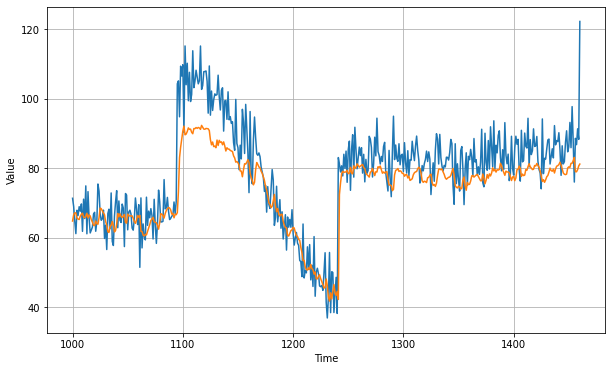

In [19]:
plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast2)

In [20]:
tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast2).numpy()

6.492768

<Figure size 432x288 with 0 Axes>

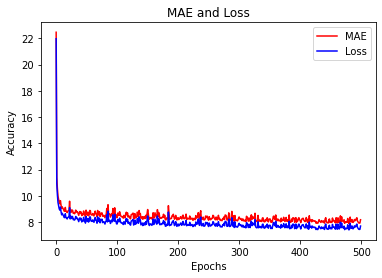

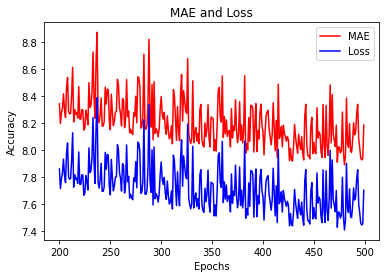

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#-------------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-------------------------------------------------------------

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))    # Get number of epochs

#-------------------------------------------------------------
# Plot MAE and Loss
#-------------------------------------------------------------

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

#-------------------------------------------------------------
# Plot Zoomed MAE and Loss
#-------------------------------------------------------------

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()